In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from dpp.data import load_from_kaggle


/Users/ebbykuriakose/Desktop/Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_link = "gagandeep16/car-sales" # replace with your dataset link from Kaggle 
destination = "../data/raw"
dataset_name = dataset_link.split("/")[-1]

files = load_from_kaggle(
    dataset_link=dataset_link, 
    destination=destination,
    )

Destination directory '../data/raw/car-sales' already exists with files. Skipping download (replace=False).


In [3]:
files

['Car_sales.csv']

In [4]:
df = pd.read_csv("/".join(["../data/raw/", dataset_name, files[0]]))
df.head()

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639


In [5]:
display(
    "Shape",
    df.shape,
    "Description",
    df.describe().round(2),
    "Duplicates",
    df.duplicated().sum(),
)


pd.DataFrame(
    {
        "Data Types": df.dtypes,
        "Missing Values": df.isnull().sum(),
        "Unique Values": df.nunique(),
        "Sample Values": [df[col].sample(3).tolist() for col in df.columns]
    })


'Shape'

(157, 16)

'Description'

,Sales_in_thousands,__year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
count,157.00,121.00,155.00,156.00,156.00,156.00,156.00,156.00,155.00,156.00,154.00,155.00
mean,53.00,18.07,27.39,3.06,185.95,107.49,71.15,187.34,3.38,17.95,23.84,77.04
std,68.03,11.45,14.35,1.04,56.70,7.64,3.45,13.43,0.63,3.89,4.28,25.14
min,0.11,5.16,9.24,1.00,55.00,92.60,62.60,149.40,1.90,10.30,15.00,23.28
25%,14.11,11.26,18.02,2.30,149.50,103.00,68.40,177.58,2.97,15.80,21.00,60.41
50%,29.45,14.18,22.80,3.00,177.50,107.00,70.55,187.90,3.34,17.20,24.00,72.03
75%,67.96,19.88,31.95,3.58,215.00,112.20,73.43,196.12,3.80,19.58,26.00,89.41
max,540.56,67.55,85.50,8.00,450.00,138.70,79.90,224.50,5.57,32.00,45.00,188.14


'Duplicates'

np.int64(0)

,Data Types,Missing Values,Unique Values,Sample Values
Manufacturer,object,0,30,"[Chrysler, Toyota, Nissan]"
Model,object,0,156,"[Elantra, LX470, Caravan]"
Sales_in_thousands,float64,0,157,"[17.531, 35.945, 63.849]"
__year_resale_value,float64,36,117,"[21.725, 27.1, 9.85]"
Vehicle_type,object,0,2,"[Passenger, Passenger, Passenger]"
Price_in_thousands,float64,2,152,"[35.3, 17.885, 21.61]"
Engine_size,float64,1,31,"[2.4, nan, 1.0]"
Horsepower,float64,1,66,"[222.0, 225.0, 175.0]"
Wheelbase,float64,1,88,"[138.7, 110.5, 120.0]"
Width,float64,1,78,"[69.5, 67.6, 72.0]"


In [6]:
#sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", center=0);

In [7]:
# Renaming __year_resale_value column
if "__year_resale_value" in df.columns:
    df.rename(columns={"__year_resale_value": "Year_resale_value"}, inplace=True)

In [8]:
# Modifying data types of object columns to categorical columns

category_col = ["Manufacturer","Model","Vehicle_type"]
for col in category_col:
    df[col] = df[col].astype("category")

df["Latest_Launch"] = pd.to_datetime(df["Latest_Launch"], errors = "coerce")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Manufacturer        157 non-null    category      
 1   Model               157 non-null    category      
 2   Sales_in_thousands  157 non-null    float64       
 3   Year_resale_value   121 non-null    float64       
 4   Vehicle_type        157 non-null    category      
 5   Price_in_thousands  155 non-null    float64       
 6   Engine_size         156 non-null    float64       
 7   Horsepower          156 non-null    float64       
 8   Wheelbase           156 non-null    float64       
 9   Width               156 non-null    float64       
 10  Length              156 non-null    float64       
 11  Curb_weight         155 non-null    float64       
 12  Fuel_capacity       156 non-null    float64       
 13  Fuel_efficiency     154 non-null    float64       

In [10]:
# Handling missing values in year_resale_value column
df["Year_resale_value"] = df["Year_resale_value"].fillna(df["Year_resale_value"].median())
df.describe().round(2)

,Sales_in_thousands,Year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
count,157.00,157.00,155.00,156.00,156.00,156.00,156.00,156.00,155.00,156.00,154.00,157,155.00
mean,53.00,17.18,27.39,3.06,185.95,107.49,71.15,187.34,3.38,17.95,23.84,2011-12-03 18:29:48.535031808,77.04
min,0.11,5.16,9.24,1.00,55.00,92.60,62.60,149.40,1.90,10.30,15.00,2008-02-13 00:00:00,23.28
25%,14.11,12.54,18.02,2.30,149.50,103.00,68.40,177.58,2.97,15.80,21.00,2011-07-07 00:00:00,60.41
50%,29.45,14.18,22.80,3.00,177.50,107.00,70.55,187.90,3.34,17.20,24.00,2011-12-10 00:00:00,72.03
75%,67.96,18.14,31.95,3.58,215.00,112.20,73.43,196.12,3.80,19.58,26.00,2012-06-02 00:00:00,89.41
max,540.56,67.55,85.50,8.00,450.00,138.70,79.90,224.50,5.57,32.00,45.00,2012-12-29 00:00:00,188.14
std,68.03,10.18,14.35,1.04,56.70,7.64,3.45,13.43,0.63,3.89,4.28,NaN,25.14


In [11]:
new_df = df[df["Price_in_thousands"].isna()]
new_df

,Manufacturer,Model,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.47,17.2,26.0,2012-01-04,NaN
33,Chrysler,Town & Country,53.480,19.540,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-07-13,NaN


In [ ]:
# Drop Chrysler Town & Country row
df = df.drop(index = 33)

# Fill Acura CL missing values with median
df["Price_in_thousands"] = df["Price_in_thousands"].fillna(df["Price_in_thousands"].median())
df["Power_perf_factor"] = df["Power_perf_factor"].fillna(df["Power_perf_factor"].median())


,Sales_in_thousands,Year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
count,156.00,156.00,156.00,156.00,156.00,156.00,156.00,156.00,155.00,156.00,154.00,156,156.00
mean,52.99,17.17,27.36,3.06,185.95,107.49,71.15,187.34,3.38,17.95,23.84,2011-12-04 16:36:55.384615424,77.01
min,0.11,5.16,9.24,1.00,55.00,92.60,62.60,149.40,1.90,10.30,15.00,2008-02-13 00:00:00,23.28
25%,14.04,12.53,18.08,2.30,149.50,103.00,68.40,177.58,2.97,15.80,21.00,2011-07-04 18:00:00,60.57
50%,29.21,14.18,22.80,3.00,177.50,107.00,70.55,187.90,3.34,17.20,24.00,2011-12-11 00:00:00,72.03
75%,68.07,17.89,31.94,3.58,215.00,112.20,73.43,196.12,3.80,19.58,26.00,2012-06-02 12:00:00,89.41
max,540.56,67.55,85.50,8.00,450.00,138.70,79.90,224.50,5.57,32.00,45.00,2012-12-29 00:00:00,188.14
std,68.25,10.21,14.31,1.04,56.70,7.64,3.45,13.43,0.63,3.89,4.28,NaN,25.06


In [13]:
new_df = df[df["Curb_weight"].isna()]
new_df

,Manufacturer,Model,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
15,Cadillac,Seville,15.943,27.1,Passenger,44.475,4.6,275.0,112.2,75.0,201.0,NaN,18.5,22.0,2011-04-29,115.621358


In [14]:
# Linear Regression model to replace Curb_weight value

# Choose predictors for Curb_weight
features = ["Length", "Width", "Engine_size", "Horsepower", "Wheelbase", "Fuel_capacity"]

# Split data into rows with and without Curb_weight
train_data = df[df["Curb_weight"].notnull()]
test_data = df[df["Curb_weight"].isnull()]

# Save indices of missing rows
missing_idx = test_data.index

# Prepare training data
X_train = train_data[features]
y_train = train_data["Curb_weight"]

# Train regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing Curb_weight
X_test = test_data[features]
predicted_values = model.predict(X_test)

# Assign predictions back
df.loc[missing_idx, "Curb_weight"] = predicted_values

# Print imputed rows horizontally
print("Rows imputed using regression:")
display(df.loc[missing_idx])


Rows imputed using regression:


,Manufacturer,Model,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
15,Cadillac,Seville,15.943,27.1,Passenger,44.475,4.6,275.0,112.2,75.0,201.0,3.816319,18.5,22.0,2011-04-29,115.621358


In [15]:
# Curb_weight replaced using median
# Create a copy of the original DataFrame to hold the results
#df_median = df.copy()

# Calculate the median of the existing (notnull) 'Curb_weight' values.
#df_median["Curb_weight"] = df_median["Curb_weight"].fillna(df_median["Curb_weight"].median())

# Display the rows that were imputed
#df_median.loc[[15]]


In [16]:
new_df = df[df["Fuel_efficiency"].isna()]
new_df

,Manufacturer,Model,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
38,Dodge,Intrepid,88.028,12.275,Passenger,22.505,2.7,202.0,113.0,74.7,203.7,3.489,17.0,NaN,2012-06-02,80.831470
109,Oldsmobile,Intrigue,38.554,14.180,Passenger,24.150,3.5,215.0,109.0,73.6,195.9,3.455,18.0,NaN,2011-04-01,86.272523


In [17]:
# Choose predictors for Fuel_efficiency
features = ["Engine_size", "Horsepower", "Curb_weight"]

# Split data into rows with and without Fuel_efficiency
train_data = df[df["Fuel_efficiency"].notnull()]
test_data  = df[df["Fuel_efficiency"].isnull()]

# Save indices of missing rows
missing_idx = test_data.index

# Prepare training data
X_train = train_data[features]
y_train = train_data["Fuel_efficiency"]

# Train regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing Fuel_efficiency values
X_test = test_data[features]
predicted_values = model.predict(X_test)

# Assign predictions back
df.loc[missing_idx, "Fuel_efficiency"] = predicted_values

# Print imputed rows horizontally
print("Rows imputed using regression:")
display(df.loc[missing_idx])

Rows imputed using regression:


,Manufacturer,Model,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
38,Dodge,Intrepid,88.028,12.275,Passenger,22.505,2.7,202.0,113.0,74.7,203.7,3.489,17.0,23.674701,2012-06-02,80.831470
109,Oldsmobile,Intrigue,38.554,14.180,Passenger,24.150,3.5,215.0,109.0,73.6,195.9,3.455,18.0,23.028418,2011-04-01,86.272523


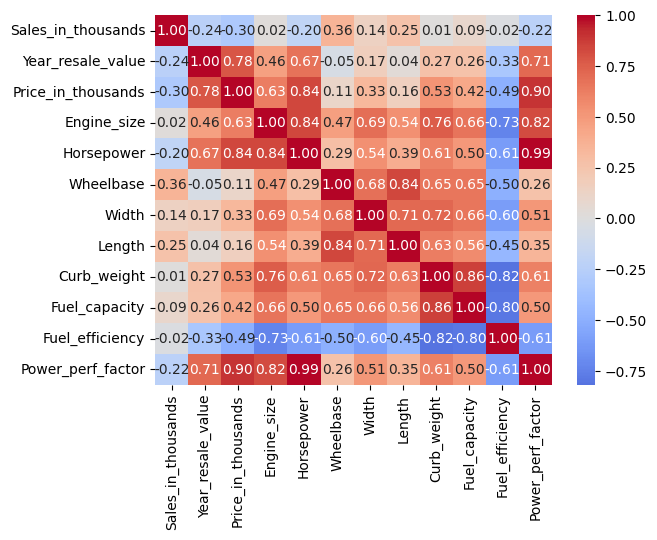

In [23]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", center=0, fmt='.2f');

In [19]:
display(df.describe())

,Sales_in_thousands,Year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156,156.000000
mean,52.994987,17.165192,27.361321,3.060897,185.948718,107.487179,71.150000,187.343590,3.380835,17.951923,23.837841,2011-12-04 16:36:55.384615424,77.011459
min,0.110000,5.160000,9.235000,1.000000,55.000000,92.600000,62.600000,149.400000,1.895000,10.300000,15.000000,2008-02-13 00:00:00,23.276272
25%,14.035000,12.527500,18.081250,2.300000,149.500000,103.000000,68.400000,177.575000,2.973000,15.800000,21.000000,2011-07-04 18:00:00,60.567577
50%,29.213000,14.180000,22.799000,3.000000,177.500000,107.000000,70.550000,187.900000,3.355000,17.200000,24.000000,2011-12-11 00:00:00,72.030917
75%,68.069750,17.892500,31.938750,3.575000,215.000000,112.200000,73.425000,196.125000,3.817489,19.575000,26.000000,2012-06-02 12:00:00,89.408406
max,540.561000,67.550000,85.500000,8.000000,450.000000,138.700000,79.900000,224.500000,5.572000,32.000000,45.000000,2012-12-29 00:00:00,188.144323
std,68.248508,10.209573,14.310006,1.044653,56.700321,7.641303,3.451872,13.431754,0.629443,3.887921,4.255507,NaN,25.064641



Column: Sales_in_thousands
Skewness: 3.40
Highly right-skewed


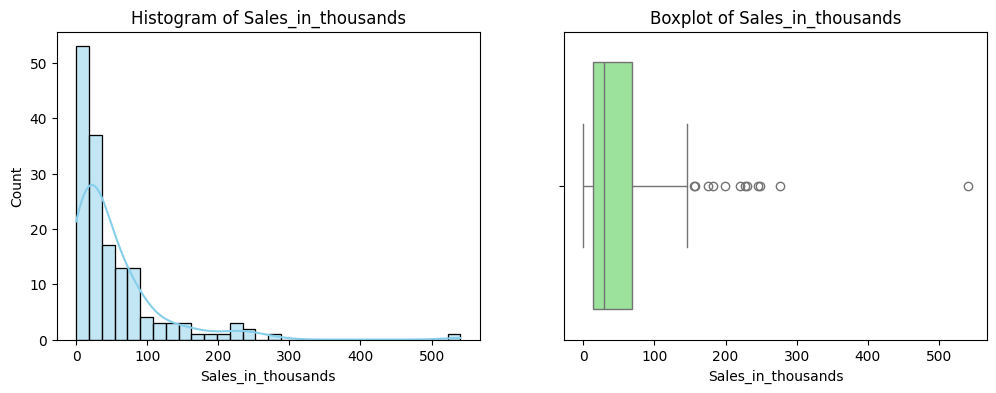


Column: Year_resale_value
Skewness: 2.76
Highly right-skewed


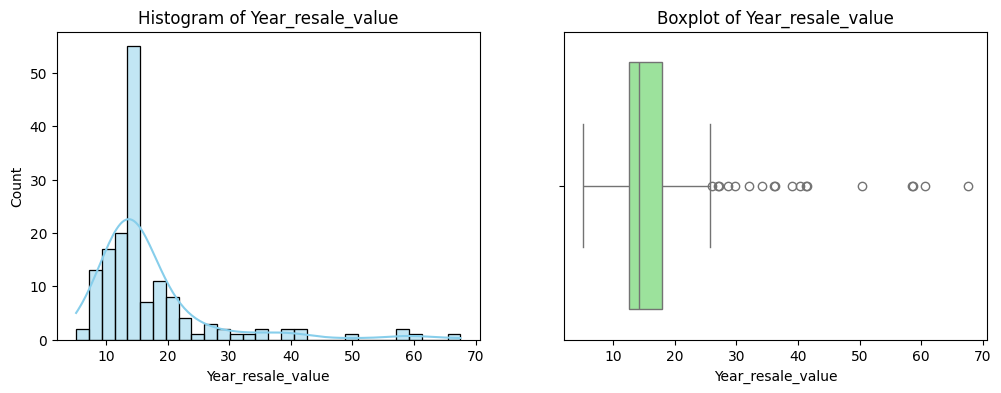


Column: Price_in_thousands
Skewness: 1.78
Highly right-skewed


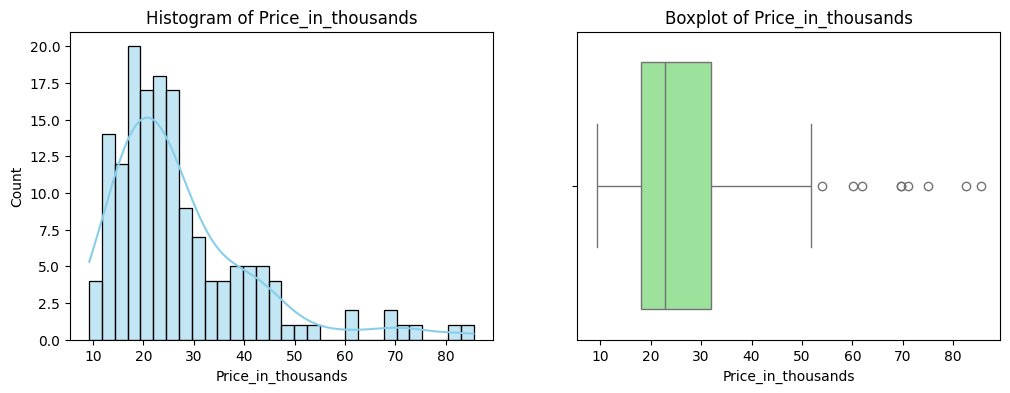


Column: Engine_size
Skewness: 1.10
Highly right-skewed


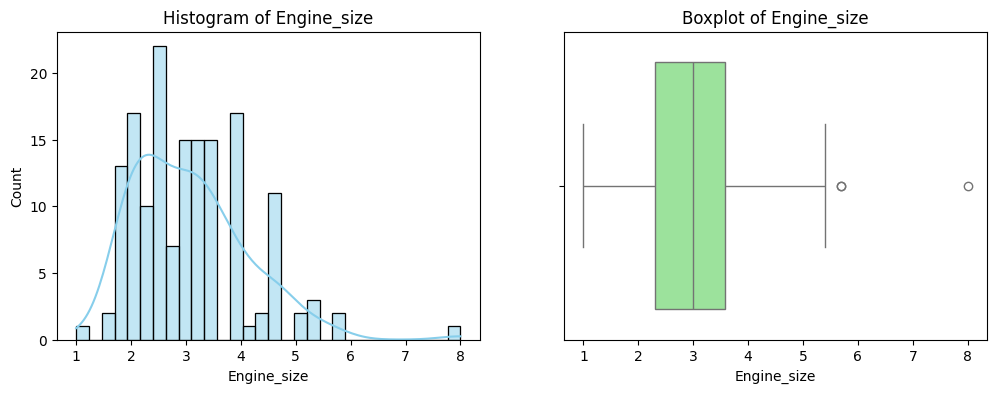


Column: Horsepower
Skewness: 1.00
Highly right-skewed


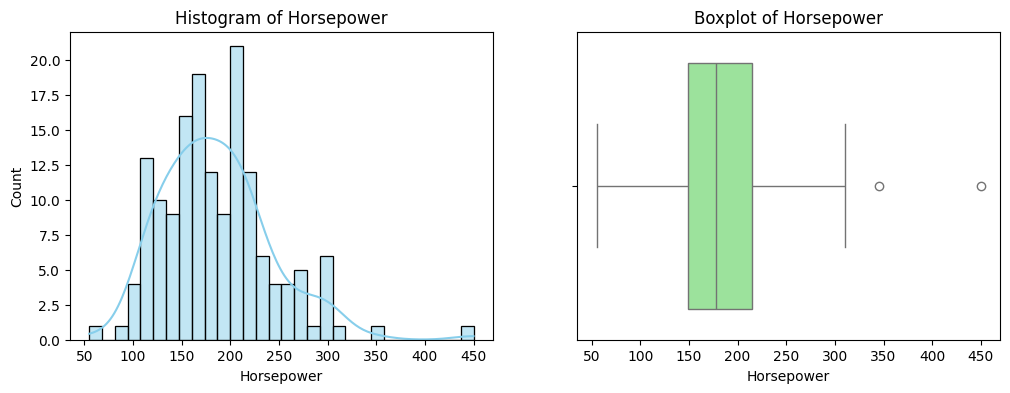


Column: Wheelbase
Skewness: 0.97
Moderately right-skewed


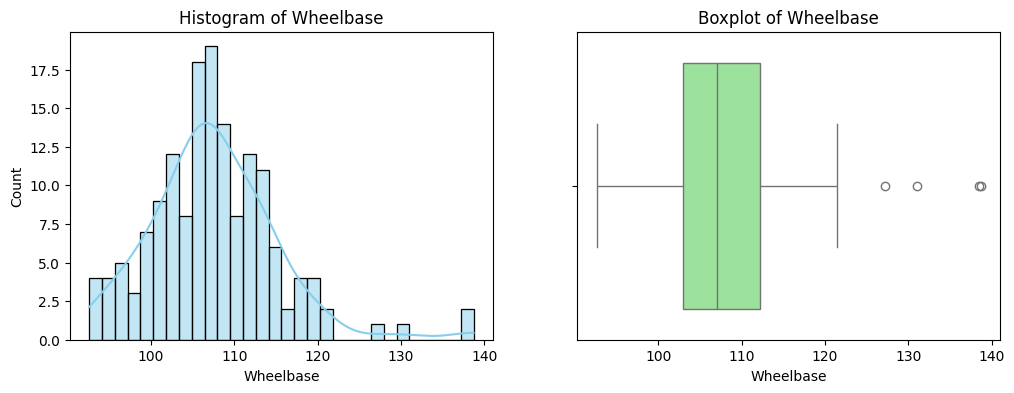


Column: Width
Skewness: 0.48
Approximately symmetric


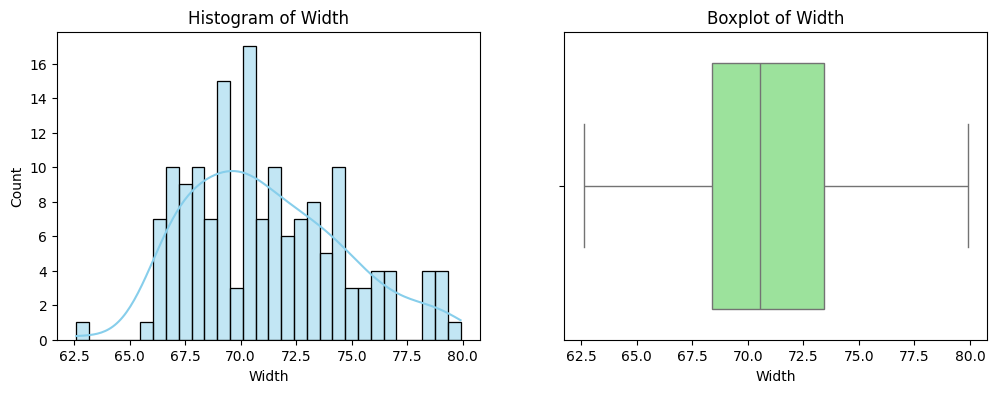


Column: Length
Skewness: -0.06
Approximately symmetric


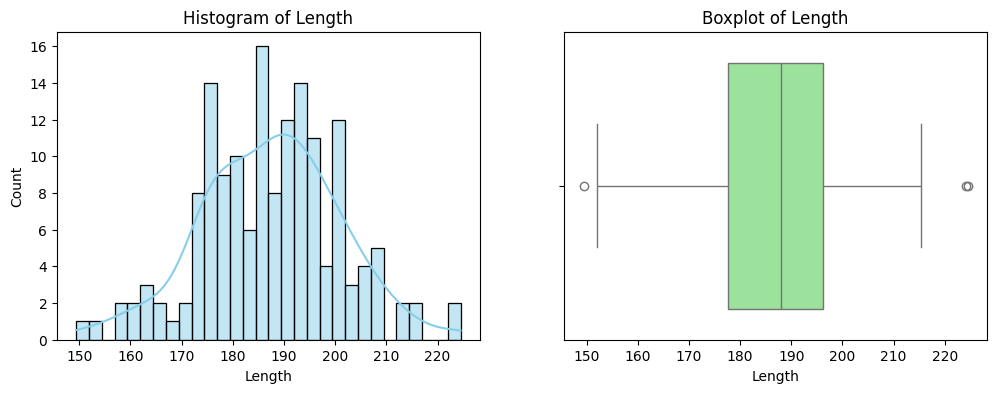


Column: Curb_weight
Skewness: 0.70
Moderately right-skewed


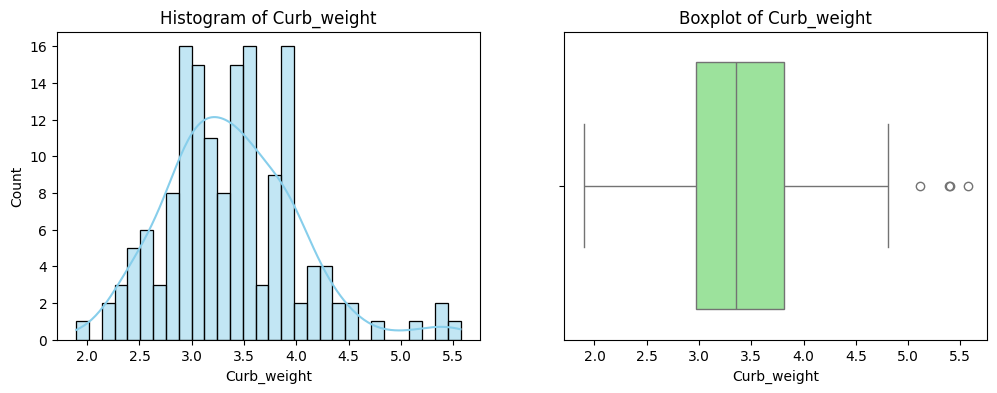


Column: Fuel_capacity
Skewness: 1.14
Highly right-skewed


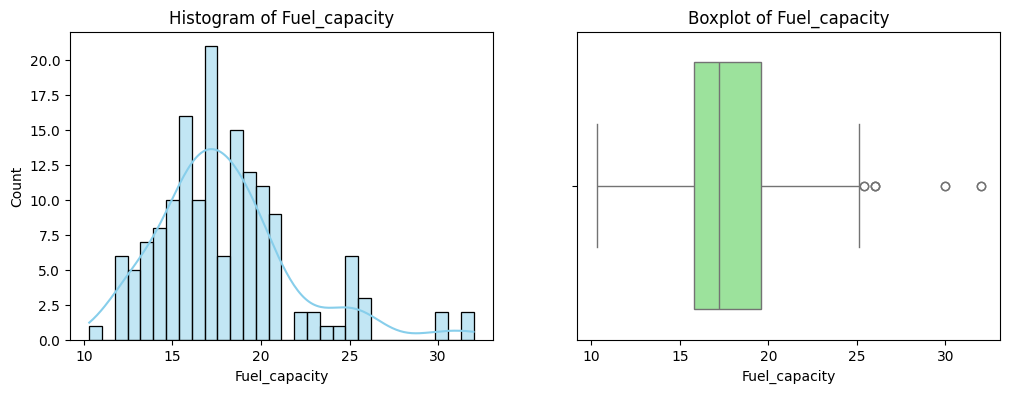


Column: Fuel_efficiency
Skewness: 0.70
Moderately right-skewed


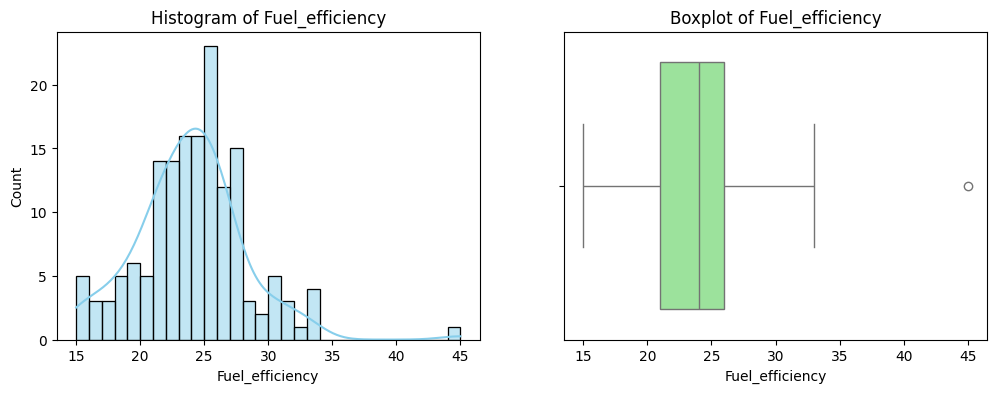


Column: Power_perf_factor
Skewness: 1.08
Highly right-skewed


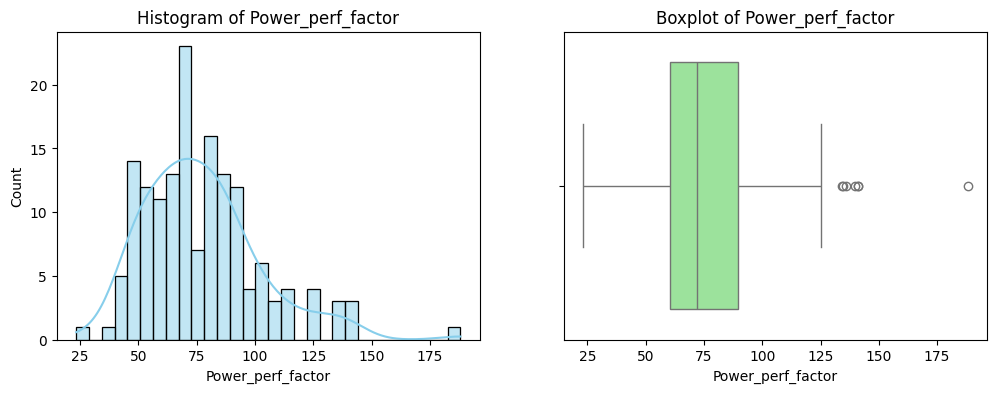

In [29]:
numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
    skewness = df[col].skew()

    print(f"\nColumn: {col}")
    print(f"Skewness: {skewness:.2f}")
    
    if skewness > 1:
        print("Highly right-skewed")
    elif skewness > 0.5:
        print("Moderately right-skewed")
    elif skewness < -1:
        print("Highly left-skewed")
    elif skewness < -0.5:
        print("Moderately left-skewed")
    else:
        print("Approximately symmetric")
    
    plt.figure(figsize=(12,4))
    
    # Histogram with KDE
    plt.subplot(1,2,1)
    sns.histplot(df[col], bins=30, kde=True, color='skyblue')
    plt.title(f"Histogram of {col}")
    
    # Boxplot
    plt.subplot(1,2,2)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f"Boxplot of {col}")
    
    plt.show()